In [1]:
from collections import defaultdict, namedtuple
import numbers
import warnings
from joblib import Parallel, delayed
import numpy as np
import sklearn

from sklearn.utils import check_array
from sklearn.ensemble._forest import ForestClassifier
from sklearn.tree import DecisionTreeClassifier as BaseDecisionTreeClassifier
import pandas as pd


In [6]:
#installing diffprivlib
#!pip3 install diffprivlib

In [2]:
#importing important libraries
import diffprivlib
from diffprivlib.accountant import BudgetAccountant
from diffprivlib.utils import PrivacyLeakWarning
from diffprivlib.mechanisms import PermuteAndFlip
from diffprivlib.validation import DiffprivlibMixin

In [3]:
#getting the data
loandf = pd.read_excel('RAIdata.xlsx')

In [4]:
loandf.head()

Unnamed: 0  Age  AppliedAmount  DebtToIncome  ExpectedLoss  \
0           0   54         8505.0           0.0      0.118622   
1           1   52         2230.0           0.0      0.059200   
2           2   28          530.0           0.0      0.048764   
3           3   40         1380.0           0.0      0.071894   
4           4   31          530.0           0.0      0.043700   

   LiabilitiesTotal  FreeCash  IncomeFromChildSupport  \
0             87.82       0.0                       0   
1            309.23       0.0                       0   
2            143.58       0.0                       0   
3             70.65       0.0                       0   
4            719.42       0.0                       0   

   IncomeFromFamilyAllowance  IncomeFromLeavePay  ...  VerificationType_2.0  \
0                        0.0                   0  ...                     0   
1                        0.0                   0  ...                     0   
2                        0.0                   0  ...                     0   
3                        0.0                   0  ...                     0   
4                        0.0                   0  ...                     0   

   VerificationType_3.0  VerificationType_4.0  WorkExperience_10To15Years  \
0                     0                     0                           0   
1                     0                     0                           0   
2                     0                     0                           0   
3                     0                     0                           0   
4                     0                     1                           0   

   WorkExperience_15To25Years  WorkExperience_2To5Years  \
0                           0                         0   
1                           0                         1   
2                           0                         1   
3                           0                         0   
4                           0                         0   

   WorkExperience_5To10Years  WorkExperience_LessThan2Years  \
0                          1                              0   
1                          0                              0   
2                          0                              0   
3                          1                              0   
4                          0                              1   

   WorkExperience_MoreThan25Years  Young  
0                               0      0  
1                               0      0  
2                               0      1  
3                               0      0  
4                               0      1  

[5 rows x 206 columns]

In [5]:
#copied the data for convinience so that if dropped some important column, dont need to load the data again
loandf1=loandf.copy()

In [6]:
loandf1['Income']= loandf1.iloc[:, 7:15].sum(axis=1)

In [7]:
loandf1['Income']

0         900.0
1         700.0
2         765.0
3        1300.0
4         950.0
          ...  
61316     900.0
61317    1656.0
61318     882.0
61319     800.0
61320    1300.0
Name: Income, Length: 61321, dtype: float64

In [8]:
loandf1.drop(loandf1.columns[[7,8,9,10,11,12,13,14]], axis =1, inplace =True)
loandf1.head()

Unnamed: 0  Age  AppliedAmount  DebtToIncome  ExpectedLoss  \
0           0   54         8505.0           0.0      0.118622   
1           1   52         2230.0           0.0      0.059200   
2           2   28          530.0           0.0      0.048764   
3           3   40         1380.0           0.0      0.071894   
4           4   31          530.0           0.0      0.043700   

   LiabilitiesTotal  FreeCash  Interest  LoanDuration  LossGivenDefault  ...  \
0             87.82       0.0     30.22            36          0.638705  ...   
1            309.23       0.0     17.53            60          0.429112  ...   
2            143.58       0.0     15.13            60          0.524213  ...   
3             70.65       0.0     19.10            60          0.471205  ...   
4            719.42       0.0     14.32            60          0.521446  ...   

   VerificationType_3.0  VerificationType_4.0  WorkExperience_10To15Years  \
0                     0                     0                           0   
1                     0                     0                           0   
2                     0                     0                           0   
3                     0                     0                           0   
4                     0                     1                           0   

   WorkExperience_15To25Years  WorkExperience_2To5Years  \
0                           0                         0   
1                           0                         1   
2                           0                         1   
3                           0                         0   
4                           0                         0   

   WorkExperience_5To10Years  WorkExperience_LessThan2Years  \
0                          1                              0   
1                          0                              0   
2                          0                              0   
3                          1                              0   
4                          0                              1   

   WorkExperience_MoreThan25Years  Young  Income  
0                               0      0   900.0  
1                               0      0   700.0  
2                               0      1   765.0  
3                               0      0  1300.0  
4                               0      1   950.0  

[5 rows x 199 columns]

In [9]:
loandf1.drop(["WrExLess10",'VerificationType_4.0', 'VerificationType_3.0', 'VerificationType_2.0', 'VerificationType_1.0'],axis =1, inplace =True)

In [10]:
list(loandf1.columns)

['Unnamed: 0',
 'Age',
 'AppliedAmount',
 'DebtToIncome',
 'ExpectedLoss',
 'LiabilitiesTotal',
 'FreeCash',
 'Interest',
 'LoanDuration',
 'LossGivenDefault',
 'MonthlyPayment',
 'ProbabilityOfDefault',
 'NrOfDependantslessthan3',
 'WrExLess5',
 'Tenant',
 'Default',
 'Country_EE',
 'Country_ES',
 'Country_FI',
 'Country_SK',
 'CreditScoreEeMini_0.0',
 'CreditScoreEeMini_600.0',
 'CreditScoreEeMini_700.0',
 'CreditScoreEeMini_800.0',
 'CreditScoreEeMini_900.0',
 'CreditScoreEeMini_1000.0',
 'CreditScoreEsEquifaxRisk_A',
 'CreditScoreEsEquifaxRisk_AA',
 'CreditScoreEsEquifaxRisk_AAA',
 'CreditScoreEsEquifaxRisk_B',
 'CreditScoreEsEquifaxRisk_C',
 'CreditScoreEsEquifaxRisk_D',
 'CreditScoreEsMicroL_M1',
 'CreditScoreEsMicroL_M2',
 'CreditScoreEsMicroL_M3',
 'CreditScoreEsMicroL_M4',
 'CreditScoreEsMicroL_M5',
 'CreditScoreEsMicroL_M6',
 'CreditScoreEsMicroL_M7',
 'CreditScoreEsMicroL_M8',
 'CreditScoreEsMicroL_M9',
 'CreditScoreEsMicroL_M10',
 'CreditScoreFiAsiakasTietoRiskGrade_RL0',
 

In [11]:
loandf1.drop(loandf1.iloc[:,20 :46], axis =1, inplace =True)

In [12]:
loandf1.drop(['WorkExperience_2To5Years','WorkExperience_10To15Years','WorkExperience_5To10Years', 'WorkExperience_LessThan2Years','WorkExperience_MoreThan25Years'], axis =1, inplace =True)

In [13]:
loandf1.head()

Unnamed: 0  Age  AppliedAmount  DebtToIncome  ExpectedLoss  \
0           0   54         8505.0           0.0      0.118622   
1           1   52         2230.0           0.0      0.059200   
2           2   28          530.0           0.0      0.048764   
3           3   40         1380.0           0.0      0.071894   
4           4   31          530.0           0.0      0.043700   

   LiabilitiesTotal  FreeCash  Interest  LoanDuration  LossGivenDefault  ...  \
0             87.82       0.0     30.22            36          0.638705  ...   
1            309.23       0.0     17.53            60          0.429112  ...   
2            143.58       0.0     15.13            60          0.524213  ...   
3             70.65       0.0     19.10            60          0.471205  ...   
4            719.42       0.0     14.32            60          0.521446  ...   

   UseOfLoan_101  UseOfLoan_102  UseOfLoan_104  UseOfLoan_106  UseOfLoan_107  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   UseOfLoan_108  UseOfLoan_110  WorkExperience_15To25Years  Young  Income  
0              0              0                           0      0   900.0  
1              0              0                           0      0   700.0  
2              0              0                           0      1   765.0  
3              0              0                           0      0  1300.0  
4              0              0                           0      1   950.0  

[5 rows x 163 columns]

In [14]:
loandf1.drop(loandf1.loc[:, 'MonthlyPaymentDay_1': 'MonthlyPaymentDay_28'], axis =1, inplace=True)
loandf1.drop(loandf1.loc[:, 'Rating_A': 'Rating_HR'], axis =1, inplace=True)
loandf1.drop(loandf1.loc[:, 'NrOfDependants_4': 'NrOfDependants_10Plus'], axis =1, inplace=True)
loandf1.drop(loandf1.loc[:, 'HomeOwnershipType_3.0': 'HomeOwnershipType_10.0'], axis =1, inplace=True)
loandf1.drop(loandf1.loc[:, 'HomeOwnershipType_0.0': 'HomeOwnershipType_2.0'], axis =1, inplace=True)
loandf1.drop(loandf1.loc[:, 'CreditScoreFiAsiakasTietoRiskGrade_RL4': 'CreditScoreFiAsiakasTietoRiskGrade_RL5'], axis =1, inplace=True)
loandf1.drop(loandf1.loc[:, 'EmploymentDurationCurrentEmployer_MoreThan5Years': 'EmploymentStatus_6.0'], axis =1, inplace=True)
loandf1.drop(loandf1.loc[:, 'UseOfLoan_0': 'UseOfLoan_110'], axis =1, inplace=True)
loandf1.drop(loandf1.loc[:, 'LanguageCode_1': 'LanguageCode_22'], axis =1, inplace=True)

In [15]:
list(loandf1.columns)

['Unnamed: 0',
 'Age',
 'AppliedAmount',
 'DebtToIncome',
 'ExpectedLoss',
 'LiabilitiesTotal',
 'FreeCash',
 'Interest',
 'LoanDuration',
 'LossGivenDefault',
 'MonthlyPayment',
 'ProbabilityOfDefault',
 'NrOfDependantslessthan3',
 'WrExLess5',
 'Tenant',
 'Default',
 'Country_EE',
 'Country_ES',
 'Country_FI',
 'Country_SK',
 'Education_1.0',
 'Education_2.0',
 'Education_3.0',
 'Education_4.0',
 'Education_5.0',
 'Gender_0.0',
 'Gender_1.0',
 'Gender_2.0',
 'MaritalStatus_1.0',
 'MaritalStatus_2.0',
 'MaritalStatus_3.0',
 'MaritalStatus_4.0',
 'MaritalStatus_5.0',
 'NewCreditCustomer_False',
 'NewCreditCustomer_True',
 'NrOfDependants_0',
 'NrOfDependants_1',
 'NrOfDependants_2',
 'NrOfDependants_3',
 'OccupationArea_-1.0',
 'OccupationArea_1.0',
 'OccupationArea_2.0',
 'OccupationArea_3.0',
 'OccupationArea_4.0',
 'OccupationArea_5.0',
 'OccupationArea_6.0',
 'OccupationArea_7.0',
 'OccupationArea_8.0',
 'OccupationArea_9.0',
 'OccupationArea_10.0',
 'OccupationArea_11.0',
 'Occupa

In [16]:
loandf1.drop(loandf1.loc[:, 'Country_EE': 'Country_SK'], axis =1, inplace=True)

In [17]:
loandf1.head()

Unnamed: 0  Age  AppliedAmount  DebtToIncome  ExpectedLoss  \
0           0   54         8505.0           0.0      0.118622   
1           1   52         2230.0           0.0      0.059200   
2           2   28          530.0           0.0      0.048764   
3           3   40         1380.0           0.0      0.071894   
4           4   31          530.0           0.0      0.043700   

   LiabilitiesTotal  FreeCash  Interest  LoanDuration  LossGivenDefault  ...  \
0             87.82       0.0     30.22            36          0.638705  ...   
1            309.23       0.0     17.53            60          0.429112  ...   
2            143.58       0.0     15.13            60          0.524213  ...   
3             70.65       0.0     19.10            60          0.471205  ...   
4            719.42       0.0     14.32            60          0.521446  ...   

   OccupationArea_13.0  OccupationArea_14.0  OccupationArea_15.0  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   OccupationArea_16.0  OccupationArea_17.0  OccupationArea_18.0  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   OccupationArea_19.0  WorkExperience_15To25Years  Young  Income  
0                    0                           0      0   900.0  
1                    0                           0      0   700.0  
2                    0                           0      1   765.0  
3                    0                           0      0  1300.0  
4                    0                           0      1   950.0  

[5 rows x 58 columns]

In [18]:
#checking if data has undefined infinite values
np.all(np.isfinite(loandf1))

False

In [19]:
#checking if data has NaN values
np.any(np.isnan(loandf1))

True

In [20]:
#removing NaN values
loandf2=loandf1.dropna().reset_index(drop=True)

In [21]:
#isolating our target feature(dependent variable)
y = loandf2['Default'].values
y = y.astype('int')

In [22]:
#getting our independent variables
X=loandf2.drop(labels=['Default'], axis=1)

In [23]:
#balancing our dataset- NOTE -I have not used the balanced dataset in the follwing column and results, there still need to test the model with balanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where
# define pipeline
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 42186, 1: 21093})


In [24]:
#train-test split 
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test=train_test_split(X,y, test_size=0.3,random_state=20)

In [25]:
X_test

Unnamed: 0  Age  AppliedAmount  DebtToIncome  ExpectedLoss  \
8923        39148   47          530.0      0.000000      0.134634   
34737       55422   67         1805.0      0.000000      0.048900   
22654       31101   37         4250.0      0.000000      0.110054   
9698        37063   41         3185.0      0.000000      0.160276   
1670        56624   66         7120.0      0.000000      0.045500   
...           ...  ...            ...           ...           ...   
18213       57657   37         2125.0      0.000000      0.111644   
62663       13084   36         3190.0     20.434465      0.085010   
7849        13025   39         1060.0      9.670000      0.074500   
29886       44766   34          530.0     20.620000      0.127031   
20966       22333   21         2655.0      0.000000      0.177494   

       LiabilitiesTotal     FreeCash  Interest  LoanDuration  \
8923           0.000000     0.000000  33.97000            36   
34737        235.880000     0.000000  16.89000            36   
22654        101.510000     0.000000  31.90000            36   
9698           0.000000     0.000000  37.60000            60   
1670         238.930000     0.000000  14.64000            60   
...                 ...          ...       ...           ...   
18213        108.870000     0.000000  28.80000            36   
62663        569.064611   351.121913  23.63217            60   
7849         875.430000  1066.570000  23.36000            24   
29886        612.350000   439.440000  27.80000            60   
20966          0.000000     0.000000  38.52000            60   

       LossGivenDefault  ...  OccupationArea_13.0  OccupationArea_14.0  \
8923           0.701939  ...                    0                    0   
34737          0.429112  ...                    0                    0   
22654          0.453868  ...                    0                    0   
9698           0.604019  ...                    0                    0   
1670           0.503720  ...                    0                    0   
...                 ...  ...                  ...                  ...   
18213          0.000000  ...                    0                    0   
62663          0.602915  ...                    0                    0   
7849           0.650000  ...                    0                    0   
29886          0.580000  ...                    0                    0   
20966          0.599315  ...                    0                    0   

       OccupationArea_15.0  OccupationArea_16.0  OccupationArea_17.0  \
8923                     0                    0                    0   
34737                    0                    0                    0   
22654                    0                    0                    0   
9698                     0                    0                    0   
1670                     0                    0                    0   
...                    ...                  ...                  ...   
18213                    0                    0                    0   
62663                    0                    0                    0   
7849                     0                    0                    0   
29886                    0                    0                    0   
20966                    0                    0                    0   

       OccupationArea_18.0  OccupationArea_19.0  WorkExperience_15To25Years  \
8923                     0                    0                           0   
34737                    0                    0                           0   
22654                    0                    0                           0   
9698                     0                    0                           0   
1670                     0                    0                           0   
...                    ...                  ...                         ...   
18213                    0                    0                           0   
62663                  

In [26]:
X_train

Unnamed: 0  Age  AppliedAmount  DebtToIncome  ExpectedLoss  \
36338       17907   28          530.0          0.00      0.076400   
2721        12341   42         1500.0         13.71      0.109465   
34649       54291   21          530.0          0.00      0.041700   
4340        59243   42         1590.0          0.00      0.040652   
3215        49363   63         3720.0          0.00      0.028200   
...           ...  ...            ...           ...           ...   
23452       10881   45         1500.0          3.94      0.123838   
23775       41513   51          850.0          0.00      0.075300   
37135       46212   63          530.0          0.00      0.065400   
27098       42268   42         1590.0          0.00      0.034200   
48483       26368   20          530.0          0.00      0.146283   

       LiabilitiesTotal  FreeCash  Interest  LoanDuration  LossGivenDefault  \
36338            775.98      0.00     22.63            36          0.439576   
2721             328.00    562.94     29.41            18          0.650000   
34649            140.15      0.00     14.32            60          0.429112   
4340             694.63      0.00     15.13            36          0.439576   
3215             101.71      0.00     12.51            36          0.518309   
...                 ...       ...       ...           ...               ...   
23452            796.00    548.90     31.69            60          0.650000   
23775            307.28      0.00     20.50            60          0.429112   
37135            596.70      0.00     20.65            36          0.380263   
27098            177.55      0.00     13.17            60          0.381588   
48483              0.00      0.00     33.15            60          0.584499   

       ...  OccupationArea_13.0  OccupationArea_14.0  OccupationArea_15.0  \
36338  ...                    0                    0                    0   
2721   ...                    0                    0                    0   
34649  ...                    0                    0                    0   
4340   ...                    0                    0                    0   
3215   ...                    0                    0                    0   
...    ...                  ...                  ...                  ...   
23452  ...                    0                    0                    0   
23775  ...                    0                    0                    0   
37135  ...                    0                    0                    0   
27098  ...                    0                    0                    0   
48483  ...                    0                    0                    0   

       OccupationArea_16.0  OccupationArea_17.0  OccupationArea_18.0  \
36338                    0                    0                    0   
2721                     0                    0                    0   
34649                    0                    0                    0   
4340                     0                    0                    0   
3215                     0                    0                    0   
...                    ...                  ...                  ...   
23452                    0                    0                    0   
23775                    0                    0                    0   
37135                    0                    0                    0   
27098                    0                    0                    0   
48483                    0                    0                    0   

       OccupationArea_19.0  WorkExperience_15To25Years  Young  Income  
36338                    0                           0      1  1560.0  
2721                     0                           1      0  2000.0  
34649                    0                           0      1   765.0  
4340                     0                           0      0  2300.0  
3215                     0                           0      0   988.0  
...    

In [27]:
np.any(np.isnan(loandf2))

False

In [28]:
#checking the fluctuation of accuracy with different epsilons in our DP RandomForest
Accofdp =[]
import warnings
warnings.filterwarnings('ignore')
from numpy import arange
from sklearn.datasets import make_classification
from diffprivlib.models import RandomForestClassifier
for i in arange(0.1, 6.0, 0.1):
    model=RandomForestClassifier(n_estimators=100,random_state=30,  epsilon=i, cat_feature_threshold=10, n_jobs=1, verbose=0, accountant=None,
                 max_depth=15, feature_domains=None)

    model.fit(X_train,y_train)
    prediction_test=model.predict(X_test)
    from sklearn.metrics import accuracy_score
    Accofdp.append(accuracy_score(y_test, prediction_test))
    
    


KeyboardInterrupt: 

In [77]:
#getting the max and min accuracy in the range of 60 epsilons
print(max(Accofdp))
print(min(Accofdp))

0.7636396483198844
0.760809346019511


In [80]:

dpmean = np.average(Accofdp)

In [82]:
import matplotlib.pyplot as plt

In [95]:
x= arange(0.1,6.0, 0.1)
plt.plot(x, Accofdp, color ='green',linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=8, label = 'Accuracy of DP RFC')
plt.style.use('seaborn-whitegrid')

plt.axhline(y=Accofreal, color ='red', label= 'Accuracy of Real RFC')
plt.axhline(y =dpmean, color ='black', label ='Avg Accuracy of DP RFC')
plt.ylim(0.7598, 0.7640)
plt.xlim(0,6)
plt.xlabel('Epsilon value')
plt.ylabel('Accuracy of model')
plt.title('Fluctuation of accuracy with epsilon')
plt.legend()
plt.show()


In [49]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
f1 =[]
recall =[]
precision =[]
pred_prob=[]

from numpy import arange
from sklearn.datasets import make_classification
from diffprivlib.models import RandomForestClassifier
for i in arange(0.1, 4.0, 0.1):
    model=RandomForestClassifier(n_estimators=100,random_state=30,  epsilon=i, cat_feature_threshold=10, n_jobs=1, verbose=0, accountant=None,
                 max_depth=15, feature_domains=None)

    model.fit(X_train,y_train)
    prediction_test=model.predict(X_test)
    from sklearn.metrics import accuracy_score
    f1.append(f1_score(y_test, prediction_test, average ='binary'))
    recall.append(recall_score(y_test, prediction_test, average ='binary'))
    precision.append(precision_score(y_test, prediction_test, average ='binary'))
    pred_prob.append(model.predict_proba(X_test)[:,0])

C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may result in additional privacy leakage. To ensure differential privacy with no additional privacy loss, specify `feature_domains` according to the documentation
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may result in additional privacy leakage. To ensure differential privacy with no additional privacy loss, specify `feature_domains` according to the documentation
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may 

In [45]:
#plotting other metrics like F1, Recall and precision
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from numpy import arange
from sklearn.datasets import make_classification
import diffprivlib.models.RandomForestClassifier
model=RandomForestClassifier(n_estimators=100,random_state=30,  epsilon=3, cat_feature_threshold=10, n_jobs=1, verbose=0, accountant=None,
                 max_depth=15, feature_domains=None)
model.fit(X_train,y_train)
prediction_test=model.predict(X_test)
from sklearn.metrics import accuracy_score
f1.append(f1_score(y_test, prediction_test, average ='binary'))
recall.append(recall_score(y_test, prediction_test, average ='binary'))
precision.append(precision_score(y_test, prediction_test, average ='binary'))
pred_prob.append(model.predict_proba(X_test)[:,0])

ImportError: cannot import name '_logistic_loss_and_grad' from 'sklearn.linear_model._logistic' (C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py)

In [53]:
f1avg = np.average(f1)
precisionavg =np.average(precision)
recallavg=np.average(recall)

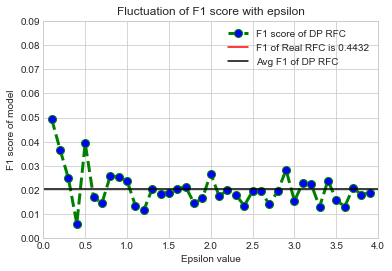

In [95]:
x= arange(0.1,4.0, 0.1)
plt.plot(x, f1, color ='green',linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=8, label = 'F1 score of DP RFC')
plt.style.use('seaborn-whitegrid')

plt.axhline(y=f1real, color ='red', label= 'F1 of Real RFC is 0.4432')
plt.axhline(y =f1avg, color ='black', label ='Avg F1 of DP RFC')
plt.ylim(0, 0.09)
plt.xlim(0,4)
plt.xlabel('Epsilon value')
plt.ylabel('F1 score of model')
plt.title('Fluctuation of F1 score with epsilon')
plt.legend()
plt.show()


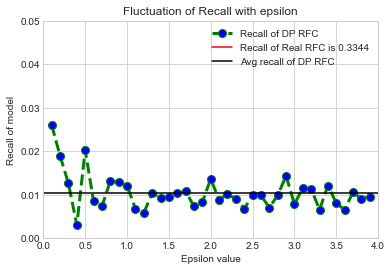

In [96]:
x= arange(0.1,4.0, 0.1)
plt.plot(x, recall, color ='green',linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=8, label = 'Recall of DP RFC')
plt.style.use('seaborn-whitegrid')

plt.axhline(y=recallreal, color ='red', label= 'Recall of Real RFC is 0.3344')
plt.axhline(y =recallavg, color ='black', label ='Avg recall of DP RFC')
plt.ylim(0, 0.05)
plt.xlim(0,4)
plt.xlabel('Epsilon value')
plt.ylabel('Recall of model')
plt.title('Fluctuation of Recall with epsilon')
plt.legend()
plt.show()

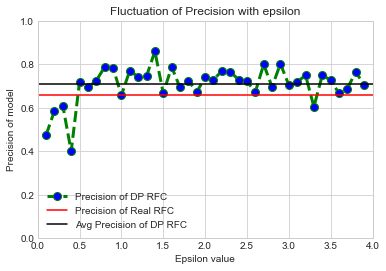

In [97]:
x= arange(0.1,4.0, 0.1)
plt.plot(x, precision, color ='green',linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=8, label = 'Precision of DP RFC')
plt.style.use('seaborn-whitegrid')

plt.axhline(y=precisionreal, color ='red', label= 'Precision of Real RFC')
plt.axhline(y =precisionavg, color ='black', label ='Avg Precision of DP RFC')
plt.ylim(0, 1)
plt.xlim(0,4)
plt.xlabel('Epsilon value')
plt.ylabel('Precision of model')
plt.title('Fluctuation of Precision with epsilon')
plt.legend()
plt.show()

In [69]:
pred_prob[0]

array([0.9 , 0.97, 0.92, ..., 0.97, 0.79, 0.94])

In [71]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr , tpr , thresholds = roc_curve ( y_test, pred_prob[0])

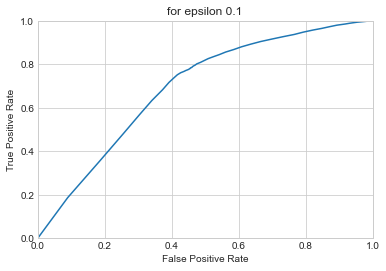

In [91]:
#plotting the roc curve for DP Random Forest with different epsilons
def plot_roc_curve(fpr,tpr, v=str()): 
    plt.plot(fpr,tpr) 
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title(v)
    plt.show()    
  
plot_roc_curve(tpr, fpr, "for epsilon 0.1")

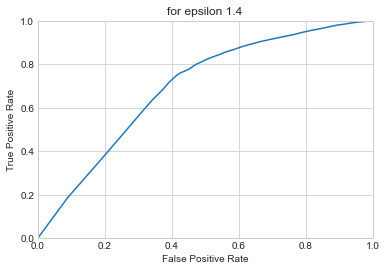

In [90]:
fpr , tpr , thresholds = roc_curve ( y_test, pred_prob[15])
plot_roc_curve(tpr, fpr, "for epsilon 1.4")

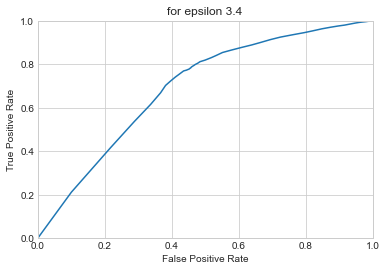

In [88]:
fpr , tpr , thresholds = roc_curve ( y_test, pred_prob[35])
plot_roc_curve(tpr, fpr, "for epsilon 3.4")

In [84]:
auc_dp0= metrics.roc_auc_score(y_test, pred_prob[35] )
auc_dp1 = 1-auc_dp0
auc_dp1

0.6923769468101688

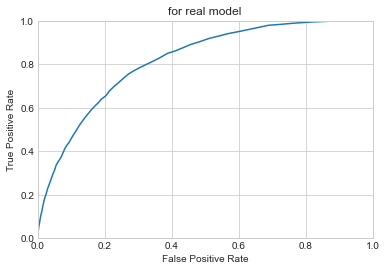

In [87]:
#plotting ROC Curve for normal model
fpr , tpr , thresholds = roc_curve ( y_test, realpred_proba1)
plot_roc_curve(fpr, tpr, "for real model")

In [83]:
#getting AUC score for normal model
from sklearn import metrics
auc_real = metrics.roc_auc_score(y_test, realpred_proba1)
auc_real

0.81705913267284

In [36]:
#nonprivate model
from sklearn.ensemble import RandomForestClassifier
model1=RandomForestClassifier(n_estimators=100,random_state=30 )
model1.fit(X_train,y_train)
prediction_test1=model1.predict(X_test)

In [99]:
#getting other metrics for our normal model, (normal model cell had been run before the private model cell,mistakenly the placement got below)
f1real = f1_score(y_test, prediction_test1, average ='binary')
recallreal = recall_score(y_test,prediction_test1, average ='binary' )
precisionreal=precision_score(y_test, prediction_test1, average ='binary')
print("F1_score of nonprivate model with nonprivate data =", f1real)
print("Recall of nonprivate model with nonprivate data =", recallreal)
print("Precision of nonprivate model with nonprivate data =", precisionreal)

F1_score of nonprivate model with nonprivate data = 0.44321608040201
Recall of nonprivate model with nonprivate data = 0.3344287158746208
Precision of nonprivate model with nonprivate data = 0.656901688182721


In [80]:
#getting prediction probabilities for label 1 of normal model(RFC)
realpred_proba1 =model1.predict_proba(X_test)[:,1]

In [34]:
#accuracy of normal model
from sklearn.metrics import accuracy_score
Accofreal = accuracy_score(y_test, prediction_test)
print ("Accuracy = ", accuracy_score(y_test, prediction_test))

Accuracy =  0.7998313862459352


In [125]:
#checking how the prediction probabilities of label 0 of a particular testcase(cust) is changing with different epsilons
#cust is customer index
cust =568
pred =[]
pred_p=[]

from numpy import arange
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from diffprivlib.models import RandomForestClassifier
epsilons = arange(1, 4, 0.5)
for epsilon in epsilons:
    model=RandomForestClassifier(n_estimators=100,random_state=30,  epsilon=epsilon, cat_feature_threshold=10, n_jobs=1, verbose=0, accountant=None,max_depth=15, feature_domains=None)
    model.fit(X_train,y_train)
    pred.append(model.predict((np.array(X_test.iloc[cust,:])).reshape(1,-1)))
    pred_p.append(model.predict_proba((np.array(X_test.iloc[cust,:])).reshape(1,-1))[:,0])
    
    
    


C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may result in additional privacy leakage. To ensure differential privacy with no additional privacy loss, specify `feature_domains` according to the documentation
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may result

In [126]:
#getting the predictions and comparing how many times we got label 0 and how many times we got label 1, for cust =568
pred.count(0), pred.count(1)

(6, 0)

In [128]:
#checking the prediction probabilities of label 0 for cust =568
pred_p

[array([1.]),
 array([0.99]),
 array([0.98]),
 array([0.99]),
 array([0.99]),
 array([0.99])]

In [131]:
#trained model once and iterated our query 50 times for cust=568 and having prediction probability of label 0 for each itme
pred_p2=[]
for i in range(0,50):
    pred_p2.append(model.predict_proba((np.array(X_test.iloc[cust,:])).reshape(1,-1))[:,0])

C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\s

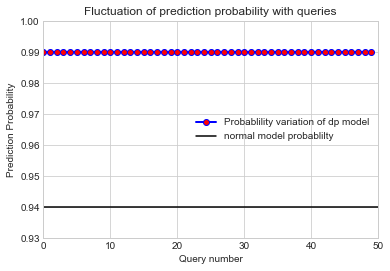

In [140]:
#line graph Dp_proba Vs Real_proba, as we can see prediction probability remains same for one iteration of training no matter how many times we predict, if the training has not been iterated then pp will not change.
import matplotlib.pyplot as plt
x_axis = range(0,50)
y_axis = pred_p2
plt.plot(x_axis, y_axis, color = 'blue', linewidth =2, marker ='o', markerfacecolor ='red', markersize =6, label ='Probablility variation of dp model')
plt.style.use('seaborn-whitegrid')
plt.ylim(0.93, 1.0)
plt.xlim(0,50)
plt.axhline(y=realpred_p, color ='black', label= 'normal model probablilty')
plt.xlabel('Query number')
plt.ylabel('Prediction Probability')
plt.title('Fluctuation of prediction probability with queries')
plt.legend()
plt.show()

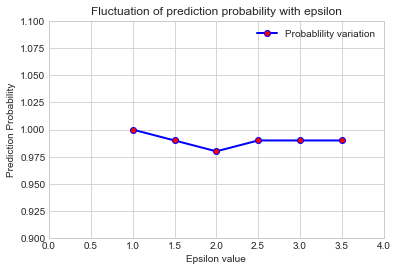

In [130]:
#line graph plotted Dp_proba fluctuatting with different epsilon for cust =568
import matplotlib.pyplot as plt
x_axis = epsilons
y_axis = pred_p
plt.plot(x_axis, y_axis, color = 'blue', linewidth =2, marker ='o', markerfacecolor ='red', markersize =6, label ='Probablility variation')
plt.style.use('seaborn-whitegrid')
plt.ylim(0.9, 1.1)
plt.xlim(0,4)
plt.xlabel('Epsilon value')
plt.ylabel('Prediction Probability')
plt.title('Fluctuation of prediction probability with epsilon')
plt.legend()
plt.show()


In [ ]:
#cust is customer index
cust =569
pred =[]
pred_p=[]

from numpy import arange
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from diffprivlib.models import RandomForestClassifier
epsilons = arange(0.1, 4, 0.3)
for epsilon in epsilons:
    model=RandomForestClassifier(n_estimators=100,random_state=30,  epsilon=epsilon, cat_feature_threshold=10, n_jobs=1, verbose=0, accountant=None,max_depth=15, feature_domains=None)
    model.fit(X_train,y_train)
    pred.append(model.predict((np.array(X_test.iloc[cust,:])).reshape(1,-1)))
    pred_p.append(model.predict_proba((np.array(X_test.iloc[cust,:])).reshape(1,-1))[:,0])

In [135]:
#predictions over different epsilons for cust=569
pred.count(0), pred.count(1)


(3, 10)

In [100]:
#prediction for 569 from normal model
cust =569
model1.predict((np.array(X_test.iloc[cust,:])).reshape(1,-1))

C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1])

In [136]:
#Actual value  as in datset of cust =569
y_test[569]

0

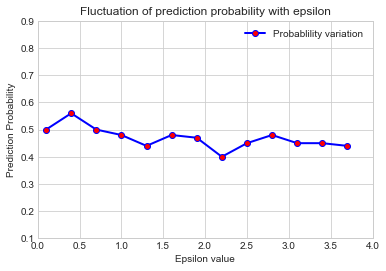

In [134]:
#line graph plotted Dp_proba fluctuatting with different epsilon for cust =569
import matplotlib.pyplot as plt
x_axis = epsilons
y_axis = pred_p
plt.plot(x_axis, y_axis, color = 'blue', linewidth =2, marker ='o', markerfacecolor ='red', markersize =6, label ='Probablility variation')
plt.style.use('seaborn-whitegrid')
plt.ylim(0.1, 0.9)
plt.xlim(0,4)
plt.xlabel('Epsilon value')
plt.ylabel('Prediction Probability')
plt.title('Fluctuation of prediction probability with epsilon')
plt.legend()
plt.show()


In [34]:
#now keeping epsilon =3, we will train and predict probabilities for label 0 20 times.
#cust is customer index
cust =569
pred =[]
pred_p=[]

from numpy import arange
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from diffprivlib.models import RandomForestClassifier

for i in range(0,20):
    model=RandomForestClassifier(n_estimators=75,random_state=30,  epsilon=3, cat_feature_threshold=10, n_jobs=1, verbose=0, accountant=None,max_depth=15, feature_domains=None)
    model.fit(X_train,y_train)
    pred.append(model.predict((np.array(X_test.iloc[cust,:])).reshape(1,-1)))
    pred_p.append(model.predict_proba((np.array(X_test.iloc[cust,:])).reshape(1,-1))[:,0])

C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may result in additional privacy leakage. To ensure differential privacy with no additional privacy loss, specify `feature_domains` according to the documentation
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may result

In [37]:
#for cust =569 noraml model prediction probability for label 0
realpred_p=(model1.predict_proba((np.array(X_test.iloc[cust,:])).reshape(1,-1))[:,0])
realpred_p

C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0.17])

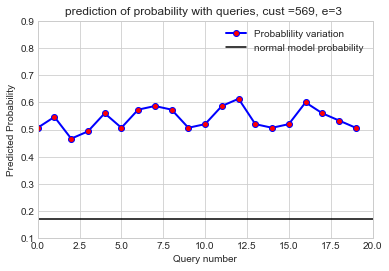

In [38]:
#line graph plotted Dp_proba fluctuatting with different queries for cust =569
import matplotlib.pyplot as plt
x_axis = range(0,20)
y_axis = pred_p
plt.plot(x_axis, y_axis, color = 'blue', linewidth =2, marker ='o', markerfacecolor ='red', markersize =6, label ='Probablility variation')
plt.style.use('seaborn-whitegrid')
plt.axhline(y =realpred_p, color = 'black', label ='normal model probability')
plt.ylim(0.1,0.9)
plt.xlim(0,20)
plt.xlabel('Query number')
plt.ylabel('Predicted Probability')
plt.title('prediction of probability with queries, cust =569, e=3 ')
plt.legend()
plt.show()

In [39]:
pred.count(0), pred.count(1)

(18, 2)

In [ ]:
#cust is customer index
cust =1987
pred =[]
pred_p=[]

from numpy import arange
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from diffprivlib.models import RandomForestClassifier

for i in range(0,20):
    model=RandomForestClassifier(n_estimators=75,random_state=30,  epsilon=3, cat_feature_threshold=10, n_jobs=1, verbose=0, accountant=None,max_depth=15, feature_domains=None)
    model.fit(X_train,y_train)
    pred.append(model.predict((np.array(X_test.iloc[cust,:])).reshape(1,-1)))
    pred_p.append(model.predict_proba((np.array(X_test.iloc[cust,:])).reshape(1,-1))[:,0])

In [159]:
pred.count(0), pred.count(1)

(20, 0)

In [164]:
pred_p

[array([0.61333333]),
 array([0.65333333]),
 array([0.65333333]),
 array([0.56]),
 array([0.53333333]),
 array([0.6]),
 array([0.56]),
 array([0.57333333]),
 array([0.56]),
 array([0.56]),
 array([0.58666667]),
 array([0.54666667]),
 array([0.58666667]),
 array([0.56]),
 array([0.6]),
 array([0.6]),
 array([0.58666667]),
 array([0.61333333]),
 array([0.57333333]),
 array([0.57333333])]

In [158]:
#predicting cust =1987 with normal model
realpred_p=(model1.predict_proba((np.array(X_test.iloc[cust,:])).reshape(1,-1))[:,0])

C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


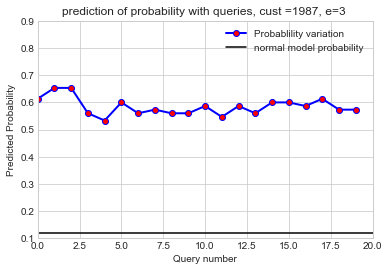

In [167]:
#line graph plotted Dp_proba fluctuatting with different queries for cust =1987
import matplotlib.pyplot as plt
x_axis = range(0,20)
y_axis = pred_p
plt.plot(x_axis, y_axis, color = 'blue', linewidth =2, marker ='o', markerfacecolor ='red', markersize =6, label ='Probablility variation')
plt.style.use('seaborn-whitegrid')
plt.axhline(y =realpred_p, color = 'black', label ='normal model probability')
plt.ylim(0.1,0.9)
plt.xlim(0,20)
plt.xlabel('Query number')
plt.ylabel('Predicted Probability')
plt.title('prediction of probability with queries, cust =1987, e=3 ')
plt.legend()
plt.show()


In [168]:
#cust is customer index
cust =4439
pred =[]
pred_p=[]

from numpy import arange
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from diffprivlib.models import RandomForestClassifier

for i in range(0,20):
    model=RandomForestClassifier(n_estimators=75,random_state=30,  epsilon=3, cat_feature_threshold=10, n_jobs=1, verbose=0, accountant=None,max_depth=15, feature_domains=None)
    model.fit(X_train,y_train)
    pred.append(model.predict((np.array(X_test.iloc[cust,:])).reshape(1,-1)))
    pred_p.append(model.predict_proba((np.array(X_test.iloc[cust,:])).reshape(1,-1))[:,0])

C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may result in additional privacy leakage. To ensure differential privacy with no additional privacy loss, specify `feature_domains` according to the documentation
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may result

In [170]:
#predicting cust =4439 with normal model
realpred_p=(model1.predict_proba((np.array(X_test.iloc[cust,:])).reshape(1,-1))[:,0])
realpred_p

C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0.27])

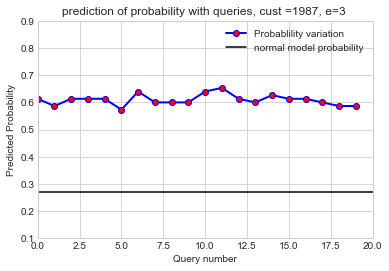

In [171]:
#line graph plotted Dp_proba fluctuatting with different queries for cust =4439
import matplotlib.pyplot as plt
x_axis = range(0,20)
y_axis = pred_p
plt.plot(x_axis, y_axis, color = 'blue', linewidth =2, marker ='o', markerfacecolor ='red', markersize =6, label ='Probablility variation')
plt.style.use('seaborn-whitegrid')
plt.axhline(y =realpred_p, color = 'black', label ='normal model probability')
plt.ylim(0.1,0.9)
plt.xlim(0,20)
plt.xlabel('Query number')
plt.ylabel('Predicted Probability')
plt.title('prediction of probability with queries, cust =4439, e=3 ')
plt.legend()
plt.show()
#graph plotted has incorrectly denoted cust =1987 but its plotted for 4439 values just the title is wrong

In [43]:
#cust is customer index
cust =1372
pred =[]
pred_p=[]

from numpy import arange
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from diffprivlib.models import RandomForestClassifier

for i in range(0,20):
    model=RandomForestClassifier(n_estimators=75,random_state=30,  epsilon=3, cat_feature_threshold=10, n_jobs=1, verbose=0, accountant=None,max_depth=15, feature_domains=None)
    model.fit(X_train,y_train)
    pred.append(model.predict((np.array(X_test.iloc[cust,:])).reshape(1,-1)))
    pred_p.append(model.predict_proba((np.array(X_test.iloc[cust,:])).reshape(1,-1))[:,0])

C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may result in additional privacy leakage. To ensure differential privacy with no additional privacy loss, specify `feature_domains` according to the documentation
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may result

In [46]:
realpred_p=(model1.predict_proba((np.array(X_test.iloc[cust,:])).reshape(1,-1))[:,0])
realpred_p

C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0.36])

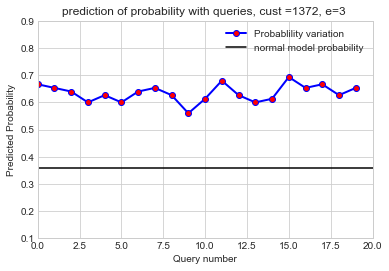

In [48]:
#line graph plotted Dp_proba fluctuatting with different queries for cust =1372
import matplotlib.pyplot as plt
x_axis = range(0,20)
y_axis = pred_p
plt.plot(x_axis, y_axis, color = 'blue', linewidth =2, marker ='o', markerfacecolor ='red', markersize =6, label ='Probablility variation')
plt.style.use('seaborn-whitegrid')
plt.axhline(y =realpred_p, color = 'black', label ='normal model probability')
plt.ylim(0.1,0.9)
plt.xlim(0,20)
plt.xlabel('Query number')
plt.ylabel('Predicted Probability')
plt.title('prediction of probability with queries, cust =1372, e=3 ')
plt.legend()
plt.show()


In [169]:
pred_p

[array([0.61333333]),
 array([0.58666667]),
 array([0.61333333]),
 array([0.61333333]),
 array([0.61333333]),
 array([0.57333333]),
 array([0.64]),
 array([0.6]),
 array([0.6]),
 array([0.6]),
 array([0.64]),
 array([0.65333333]),
 array([0.61333333]),
 array([0.6]),
 array([0.62666667]),
 array([0.61333333]),
 array([0.61333333]),
 array([0.6]),
 array([0.58666667]),
 array([0.58666667])]

In [119]:
Pred = model.predict(X_test)

In [126]:
#checking for which values dp model predicted '1'
count =0
for i in range(0,5000):
    if(Pred[i] == 1):
        print(i)
        count +=1
count

569
1199
1229
1314
1372
1512
1987
2707
2746
3253
3270
3553
3908
4140
4439
4532
4800
4864


18

In [101]:
#added noise to few features to test the model prediction with similar data points
dploan = loandf2.copy(deep =True)

In [102]:
dploan.head()

Unnamed: 0  Age  AppliedAmount  DebtToIncome  ExpectedLoss  \
0           0   54         8505.0           0.0      0.118622   
1           1   52         2230.0           0.0      0.059200   
2           2   28          530.0           0.0      0.048764   
3           3   40         1380.0           0.0      0.071894   
4           4   31          530.0           0.0      0.043700   

   LiabilitiesTotal  FreeCash  Interest  LoanDuration  LossGivenDefault  ...  \
0             87.82       0.0     30.22            36          0.638705  ...   
1            309.23       0.0     17.53            60          0.429112  ...   
2            143.58       0.0     15.13            60          0.524213  ...   
3             70.65       0.0     19.10            60          0.471205  ...   
4            719.42       0.0     14.32            60          0.521446  ...   

   OccupationArea_13.0  OccupationArea_14.0  OccupationArea_15.0  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   OccupationArea_16.0  OccupationArea_17.0  OccupationArea_18.0  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   OccupationArea_19.0  WorkExperience_15To25Years  Young  Income  
0                    0                           0      0   900.0  
1                    0                           0      0   700.0  
2                    0                           0      1   765.0  
3                    0                           0      0  1300.0  
4                    0                           0      1   950.0  

[5 rows x 58 columns]

In [103]:
senstivity =1
epsilon =0.1
dp_age=[]

original = loandf2['Age']

for i in range(0,55353):
        value=original[i] +  np.random.laplace(loc=0, scale=senstivity/epsilon)
        value = round(value)
        dp_age.append(value)

        
dploan['Age']=dp_age      

In [105]:
senstivity =1
epsilon =0.1
dp_AppliedAmount=[]

original = loandf2['AppliedAmount']

for i in range(0,55353):
        value=original[i] +  np.random.laplace(loc=0, scale=senstivity/epsilon)
        value = round(value)
        dp_AppliedAmount.append(value)
dploan['AppliedAmount']=dp_AppliedAmount

In [106]:
senstivity =1
epsilon =0.1
dp_ExpectedLoss=[]

original = loandf2['ExpectedLoss']

for i in range(0,55353):
        value=original[i] +  np.random.laplace(loc=0, scale=senstivity/epsilon)
        value = round(value)
        dp_ExpectedLoss.append(value)

dploan['ExpectedLoss']=dp_ExpectedLoss

In [107]:
senstivity =1
epsilon =0.1
dp_Income=[]

original = loandf2['Income']

for i in range(0,55353):
        value=original[i] +  np.random.laplace(loc=0, scale=senstivity/epsilon)
        value = round(value)
        dp_Income.append(value)
dploan['Income']=dp_Income

In [108]:
senstivity =1
epsilon =1
dp_Liabilities=[]

original = loandf2['LiabilitiesTotal']

for i in range(0,55353):
        value=original[i] +  np.random.laplace(loc=0, scale=senstivity/epsilon)
        value = round(value)
        dp_Liabilities.append(value)
dploan['LiabilitiesTotal']=dp_Liabilities

In [109]:
y_dp = dploan['Default'].values
y_dp = y.astype('int')
X_dp=dploan.drop(labels=['Default'], axis=1)
from sklearn.model_selection import train_test_split
X_dptrain, X_dptest,y_dptrain, y_dptest=train_test_split(X_dp,y_dp, test_size=0.3,random_state=20)

In [124]:
#iterating 20 times with same epsilon and predicting it over similar data point of cust =1229
pred1=[]
pred_p1=[]
cust =1229
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from diffprivlib.models import RandomForestClassifier
for i in range(0,20):
    model=RandomForestClassifier(n_estimators=100,random_state=30,  epsilon=3, cat_feature_threshold=10, n_jobs=1, verbose=0, accountant=None,
                 max_depth=15, feature_domains=None)

    model.fit(X_train,y_train)
    pred1.append(model.predict((np.array(X_dptest.iloc[cust,:])).reshape(1,-1)))
    pred_p1.append(model.predict_proba((np.array(X_dptest.iloc[cust,:])).reshape(1,-1))[:,0])


C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may result in additional privacy leakage. To ensure differential privacy with no additional privacy loss, specify `feature_domains` according to the documentation
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may result

In [149]:
#actual value for 1229
y_test[1229]

1

In [146]:
#non private model predicts "1" too for a similar 1229 data point
cust =1229
realpred_p=(model1.predict_proba((np.array(X_dptest.iloc[cust,:])).reshape(1,-1))[:,0])
realpred_p

C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0.25])

In [144]:
#private model predicts sometimes 0, sometimes 1 hence embedding the privacy
pred1.count(0), pred1.count(1)

(13, 7)

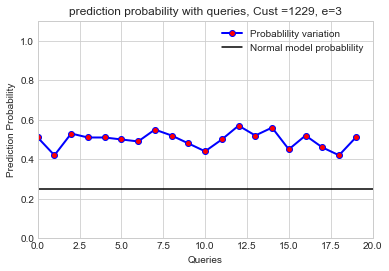

In [148]:
#pltted graph for different queries with 1229 similar data point
import matplotlib.pyplot as plt
x_axis = range(0,20)
y_axis = pred_p1
plt.plot(x_axis, y_axis, color = 'blue', linewidth =2, marker ='o', markerfacecolor ='red', markersize =6, label ='Probablility variation')
plt.style.use('seaborn-whitegrid')
plt.axhline(y = realpred_p, color ='black', label ='Normal model probablility')
plt.ylim(0, 1.1)
plt.xlim(0,20)
plt.xlabel('Queries')
plt.ylabel('Prediction Probability')
plt.title('prediction probability with queries, Cust =1229, e=3')
plt.legend()
plt.show()

In [142]:
pred_p1

[array([0.51]),
 array([0.42]),
 array([0.53]),
 array([0.51]),
 array([0.51]),
 array([0.5]),
 array([0.49]),
 array([0.55]),
 array([0.52]),
 array([0.48]),
 array([0.44]),
 array([0.5]),
 array([0.57]),
 array([0.52]),
 array([0.56]),
 array([0.45]),
 array([0.52]),
 array([0.46]),
 array([0.42]),
 array([0.51])]